In [1]:
import sys
sys.path.append("../")


from scipy.sparse.csgraph import reverse_cuthill_mckee
from sklearn.metrics import pairwise_distances, pairwise
from scipy.sparse import csr_matrix
import matplotlib.gridspec as gridspec

import os
import math
import time
import numpy as np
import pandas as pd
from collections import Counter
import random

import torch
import torch_geometric
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [2]:
!python --version

Python 3.8.8


In [3]:
os.listdir("../../../Downloads/sst_dataset_old/")

['sst.day.mean.1982.nc',
 'sst.day.mean.1983.nc',
 'sst.day.mean.1987.nc',
 'sst.day.mean.1984.nc',
 'sst.day.mean.1985.nc',
 'sst.day.mean.1986.nc']

In [4]:
os.listdir("../../../Public/sst_dataset")

['sst.day.mean.2018.nc',
 'sst.day.mean.1987.nc',
 'sst.day.mean.2013.nc',
 'sst.day.mean.2010.nc',
 'sst.day.mean.2004.nc',
 'sst.day.mean.1982.nc',
 'sst.day.mean.2021.nc',
 'sst.day.mean.2007.nc',
 'sst.day.mean.2003.nc',
 'sst.day.mean.1985.nc',
 'sst.day.mean.1983.nc',
 'sst.day.mean.2020.nc',
 'sst.day.mean.2012.nc',
 'sst.day.mean.2009.nc',
 'sst.day.mean.2014.nc',
 'sst.day.mean.2005.nc',
 'sst.day.mean.2008.nc',
 'sst.day.mean.1991.nc',
 'sst.day.mean.1988.nc',
 'sst.day.mean.1999.nc',
 'sst.day.mean.2006.nc',
 'sst.day.mean.2022.nc',
 'sst.day.mean.2011.nc',
 'sst.day.mean.2019.nc',
 'sst.day.mean.2017.nc',
 'sst.day.mean.2002.nc',
 'sst.day.mean.1984.nc',
 'sst.day.mean.1990.nc',
 'sst.day.mean.1989.nc',
 'sst.day.mean.1994.nc',
 'sst.day.mean.2000.nc',
 'sst.day.mean.1986.nc',
 'sst.day.mean.1996.nc',
 'sst.day.mean.1998.nc',
 'sst.day.mean.1997.nc',
 'sst.day.mean.1995.nc',
 'sst.day.mean.2015.nc',
 'sst.day.mean.2016.nc',
 'sst.day.mean.2023.nc',
 'sst.day.mean.1992.nc',


In [5]:
import xarray
data = xarray.open_mfdataset("../../../Downloads/sst_dataset_old/*.nc",engine = "netcdf4")

In [6]:
data_sst = data.sst[:,410:510,990:990+180].values

In [7]:
data.sst[:,410:510,990:990+180]

<xarray.DataArray 'sst' (time: 2191, lat: 100, lon: 180)>
dask.array<getitem, shape=(2191, 100, 180), dtype=float32, chunksize=(366, 100, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1987-12-31
  * lat      (lat) float32 12.62 12.88 13.12 13.38 ... 36.62 36.88 37.12 37.38
  * lon      (lon) float32 247.6 247.9 248.1 248.4 ... 291.6 291.9 292.1 292.4
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

In [8]:
data.sst[:,410:510,990:990+180]

<xarray.DataArray 'sst' (time: 2191, lat: 100, lon: 180)>
dask.array<getitem, shape=(2191, 100, 180), dtype=float32, chunksize=(366, 100, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1987-12-31
  * lat      (lat) float32 12.62 12.88 13.12 13.38 ... 36.62 36.88 37.12 37.38
  * lon      (lon) float32 247.6 247.9 248.1 248.4 ... 291.6 291.9 292.1 292.4
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

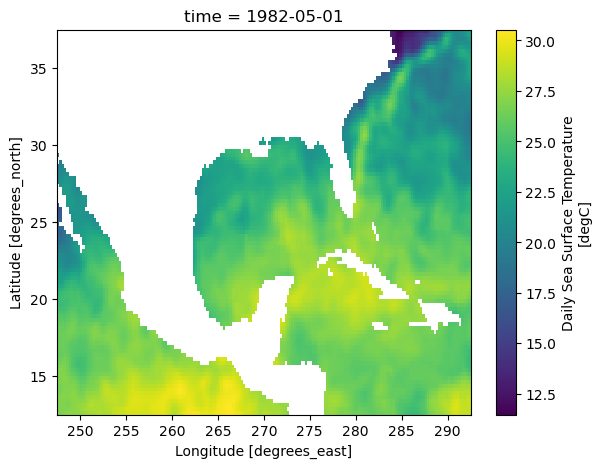

In [9]:
air2d = data.sst[:,410:510,990:990+180].isel(time=120)

air2d.plot(aspect="auto",size = 5)

In [10]:
nanflag = ~np.isnan(data_sst[0])

In [11]:
nanflag

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [12]:
np.nanmin(data_sst)

1.23

In [13]:
data_sst[np.isnan(data_sst)] = 0

In [14]:
np.max(data_sst)

33.399998

In [15]:
np.argmax(data_sst,axis=0)

array([[ 283,  283,  283, ..., 2052, 2052, 2052],
       [ 283,  678,  283, ..., 2052, 2052, 2052],
       [ 215,  677, 1705, ...,  548,  549, 2052],
       ...,
       [   0,    0,    0, ...,  946,  195,  196],
       [   0,    0,    0, ...,  194,  615,  201],
       [   0,    0,    0, ...,  606,  203,  203]])

/tmp/ipykernel_2787295/257209988.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


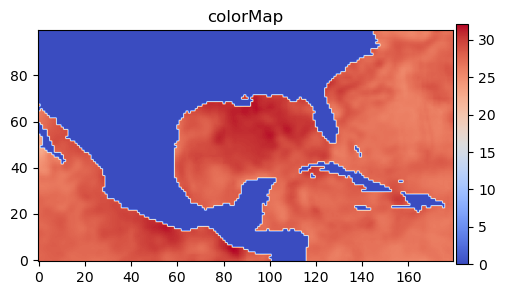

In [16]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(data_sst[210],origin='lower',cmap='coolwarm')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [17]:
nanflag.shape

(100, 180)

In [18]:
np.save("sst/sst_gulf_mexico_82_87.npy", data_sst)
np.save("sst/sst_gulf_mexico_82_87_nanflag.npy",nanflag)

In [19]:
#CHANGE BELOW DEPENDING ON FOLDER

In [20]:
seed = 0

In [21]:
import scipy.io
mat = scipy.io.loadmat('results/results_det_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))

In [22]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pred', 'truth', 'init'])

In [23]:
mat['pred'].shape

(180, 100, 180)

/tmp/ipykernel_2787295/1671655055.py:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


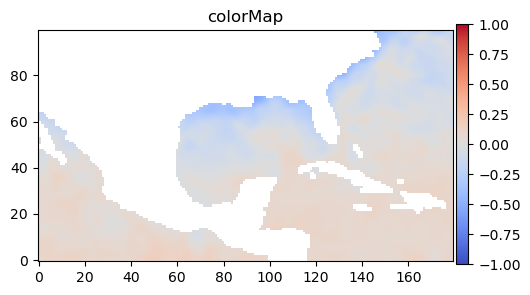

In [24]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
data = mat['pred'][150]
data[~nanflag] = np.nan

plt.imshow(data,origin='lower',cmap='coolwarm',vmin=-1, vmax=1)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

/tmp/ipykernel_2787295/2213407248.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


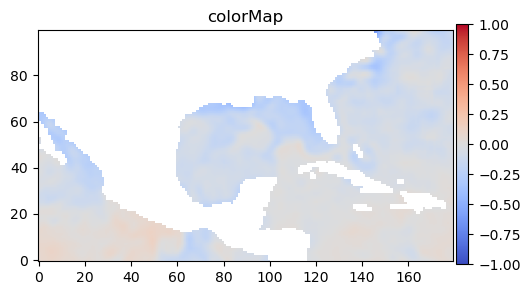

In [25]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')

data = mat['truth'][150]
data[~nanflag] = np.nan

plt.imshow(data,origin='lower',cmap='coolwarm',vmin=-1, vmax=1)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

/tmp/ipykernel_2787295/3847553450.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


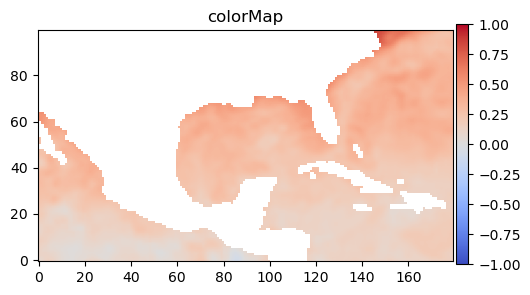

In [26]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')

data = mat['init']
data[~nanflag] = np.nan

plt.imshow(data,origin='lower',cmap='coolwarm',vmin=-1, vmax=1)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

-0.0722906
0.8373282
-0.60639787
0.82754517
-0.6772499
0.82688016
-0.6876044
0.85331804
-0.79428184
0.8657892
-0.79428184
0.8657892


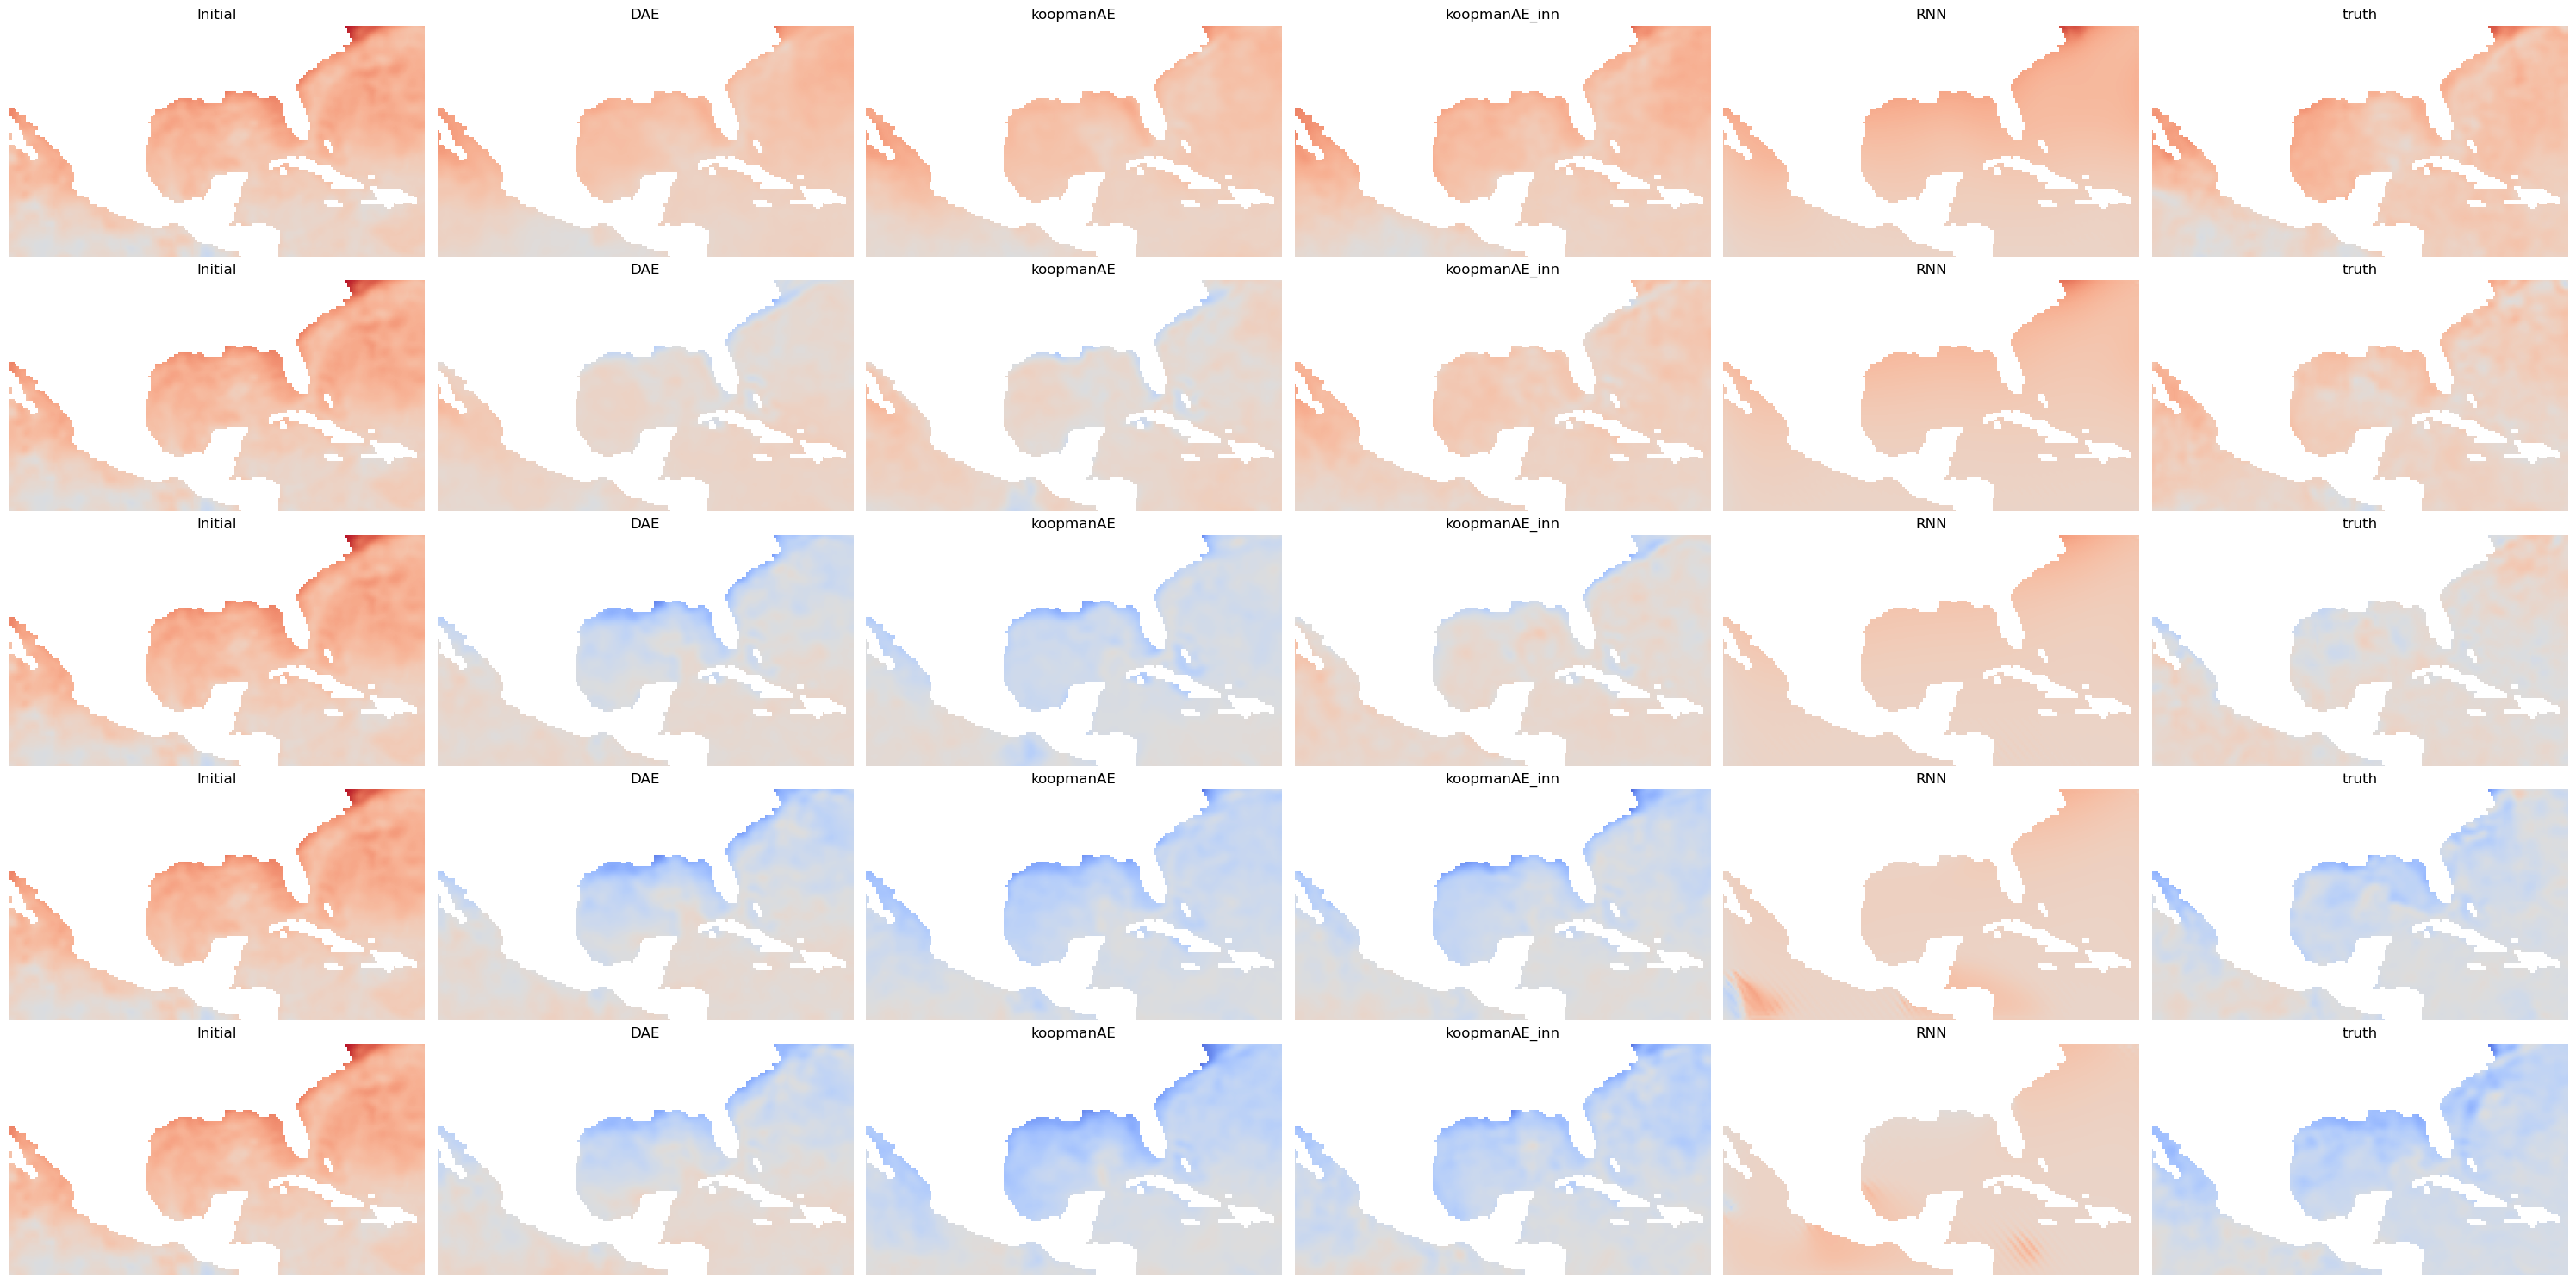

In [35]:
init = scipy.io.loadmat('results/results_det_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['init']
init[~nanflag] = np.nan

print(np.nanmin(init))
print(np.nanmax(init))

DAE = scipy.io.loadmat('results/results_det_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['pred']
DAE[:,~nanflag] = np.nan

print(np.nanmin(DAE))
print(np.nanmax(DAE))

koopmanAE = scipy.io.loadmat('results/results_det_back_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE[:,~nanflag] = np.nan

print(np.nanmin(koopmanAE))
print(np.nanmax(koopmanAE))

koopmanAE_INN = scipy.io.loadmat('results/results_det_back_inn_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE_INN[:,~nanflag] = np.nan

print(np.nanmin(koopmanAE_INN))
print(np.nanmax(koopmanAE_INN))

RNN = scipy.io.loadmat('results/results_sst_convlstm_seed_0/snapshots_pred.mat')['pred']
RNN[:,~nanflag] = np.nan


truth = scipy.io.loadmat('results/results_det_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['truth']
truth[:,~nanflag] = np.nan

print(np.nanmin(truth))
print(np.nanmax(truth))

vmax= max( np.nanmax(init),np.nanmax(DAE),np.nanmax(koopmanAE),np.nanmax(koopmanAE_INN),np.nanmax(truth))
vmin= min( np.nanmin(init),np.nanmin(DAE),np.nanmin(koopmanAE),np.nanmin(koopmanAE_INN),np.nanmin(truth))


print(vmin)
print(vmax)





# create a figure with 5 x 5 subplots
fig, axes = plt.subplots(5, 6, figsize=(30, 15))


# get a 1-dimensional list of axis objects
ax_list = list(axes.flat)[::-1]
num_subplots = len(ax_list)

for i in range(int(num_subplots/6)):
    # generate random y values and plot this series
    ax = ax_list.pop()
    ax.imshow(init,origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("Initial")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(DAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("DAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("koopmanAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE_INN[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("koopmanAE_inn")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(RNN[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("RNN")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(truth[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("truth")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
# display the figure


fig.tight_layout()
plt.show()

DAE 0.06153938
koopmanAE 0.056377083
koopmanAE_INN 0.044573404
RNN 0.09599374
truth 0.0


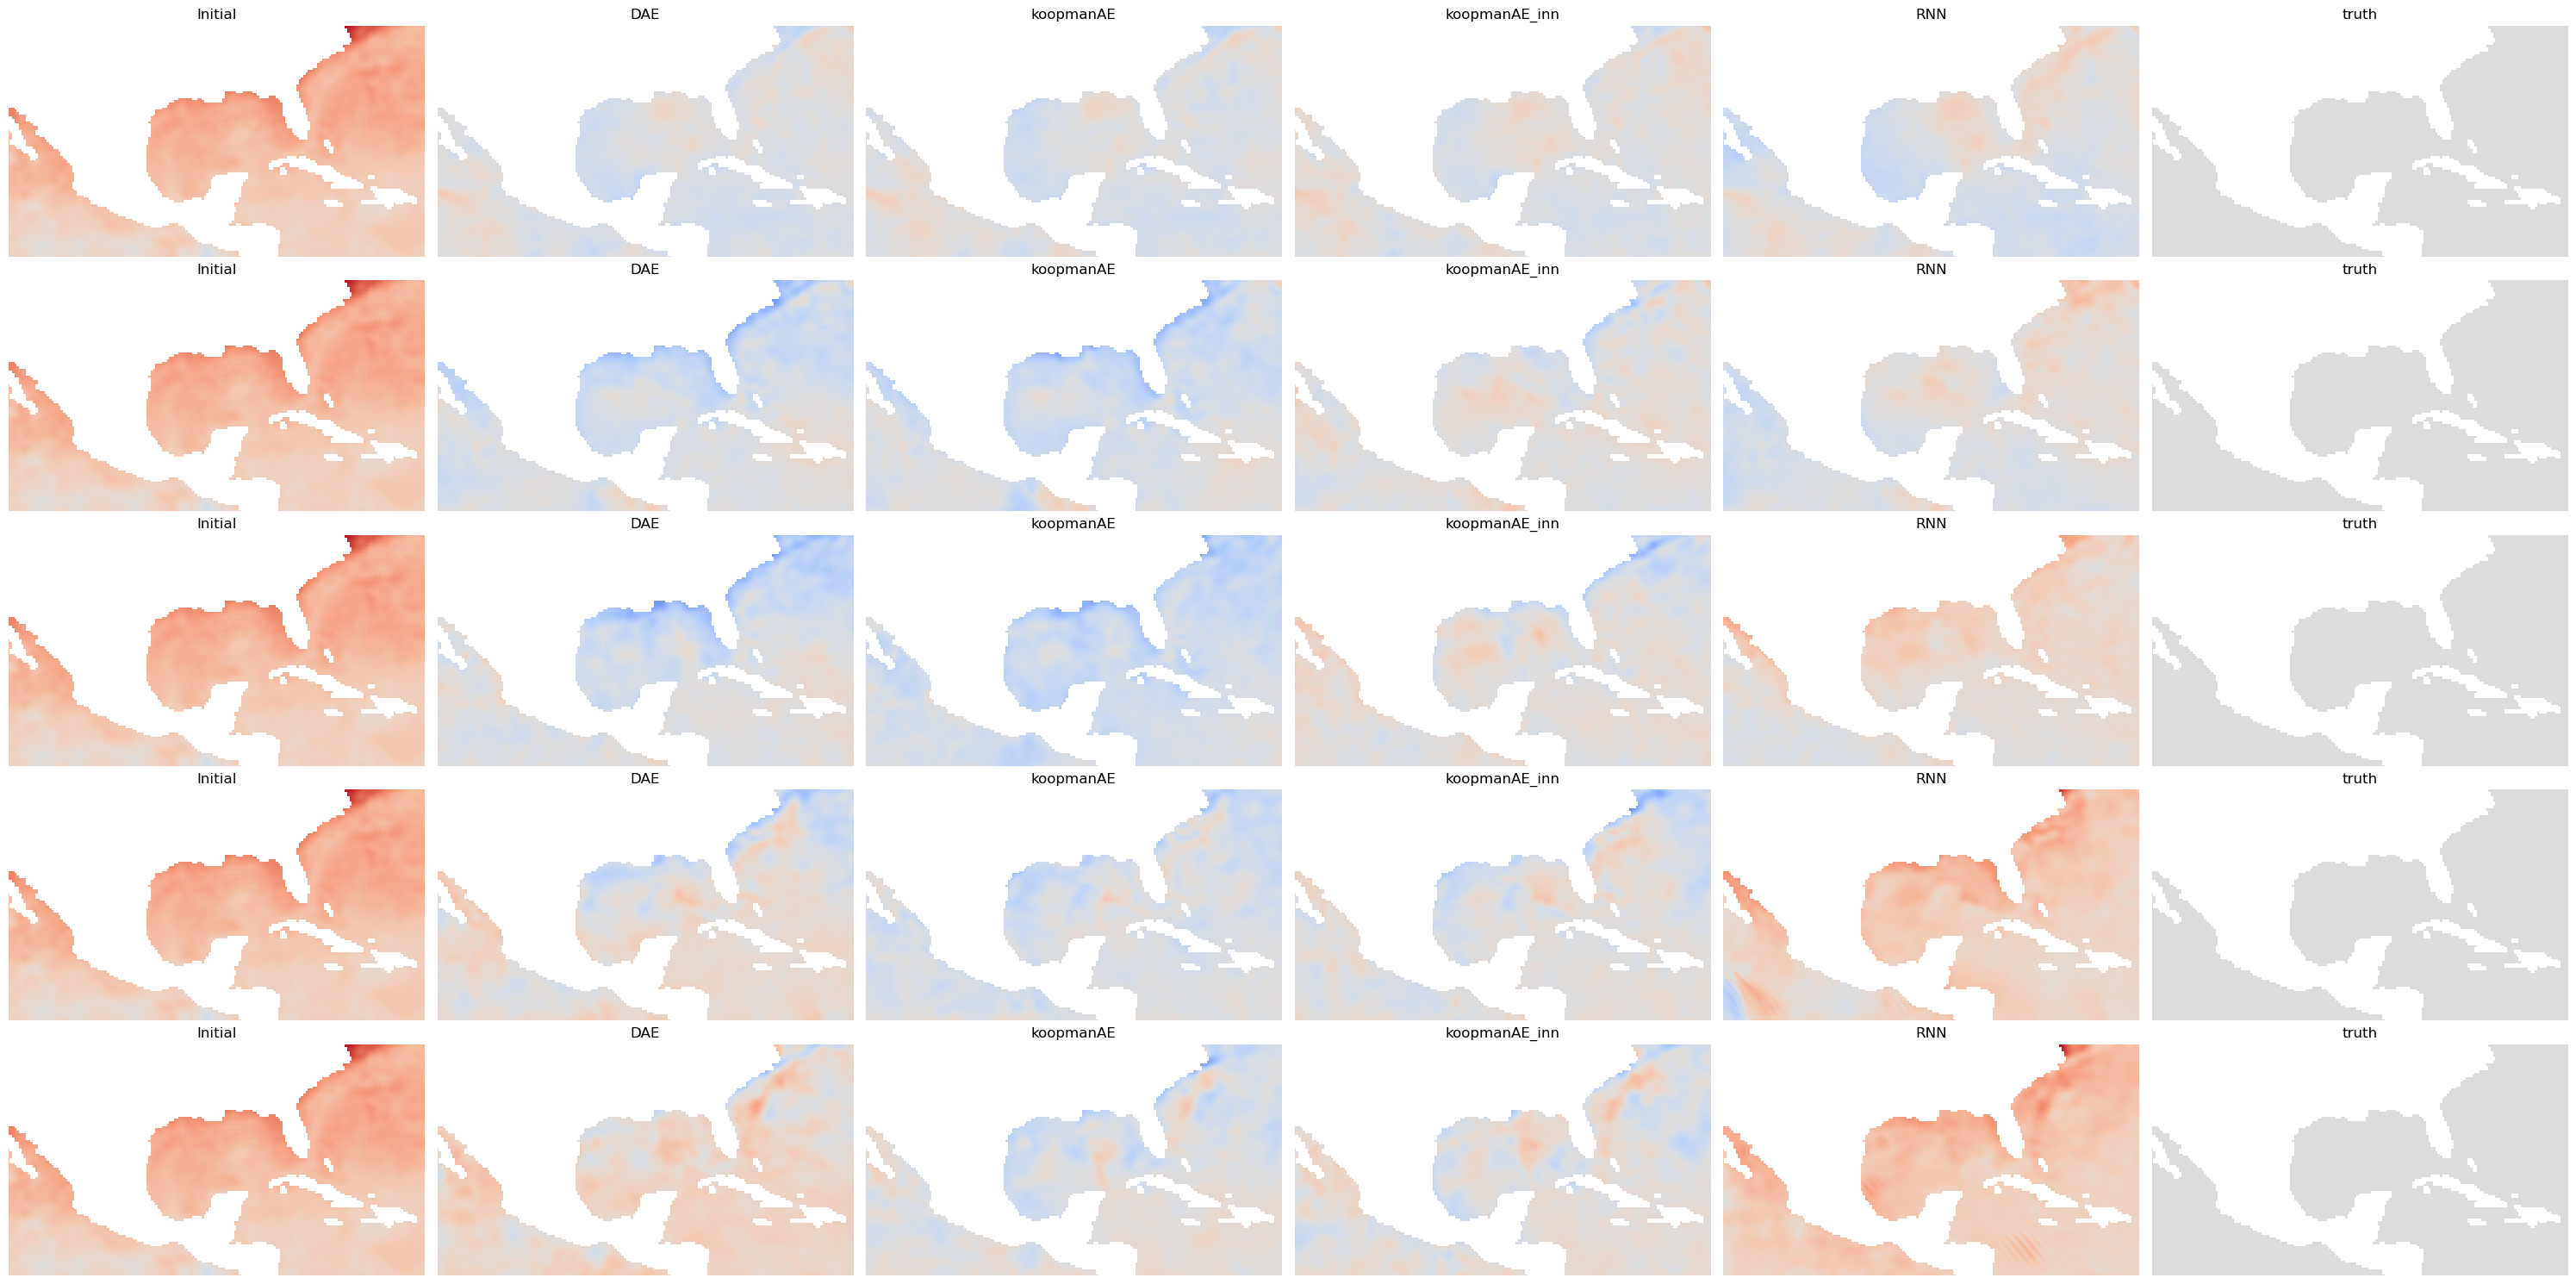

In [34]:
init = scipy.io.loadmat('results/results_det_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['init']
init[~nanflag] = np.nan

# print(np.nanmin(init))
# print(np.nanmax(init))


truth = scipy.io.loadmat('results/results_det_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['truth']
truth[:,~nanflag] = np.nan




# print(np.nanmin(truth))
# print(np.nanmax(truth))



DAE = scipy.io.loadmat('results/results_det_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['pred']
DAE[:,~nanflag] = np.nan
DAE = DAE - truth 
print("DAE",np.nanmean(np.abs(DAE)))

# print(np.nanmin(DAE))
# print(np.nanmax(DAE))

koopmanAE = scipy.io.loadmat('results/results_det_back_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE[:,~nanflag] = np.nan
koopmanAE = koopmanAE - truth 
print("koopmanAE",np.nanmean(np.abs(koopmanAE)))


# print(np.nanmin(koopmanAE))
# print(np.nanmax(koopmanAE))

koopmanAE_INN = scipy.io.loadmat('results/results_det_back_inn_sst_alpha6_bottle_10_steps_14_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE_INN[:,~nanflag] = np.nan
koopmanAE_INN = koopmanAE_INN - truth 
print("koopmanAE_INN",np.nanmean(np.abs(koopmanAE_INN)))

RNN = scipy.io.loadmat('results/results_sst_convlstm_seed_0/snapshots_pred.mat')['pred']
RNN[:,~nanflag] = np.nan
RNN = RNN - truth 
print("RNN",np.nanmean(np.abs(RNN)))

# print(np.nanmin(koopmanAE_INN))
# print(np.nanmax(koopmanAE_INN))


# print(np.nanmin(X_prev))
# print(np.nanmax(X_prev))



vmax= max( np.nanmax(init),np.nanmax(DAE),np.nanmax(koopmanAE),np.nanmax(koopmanAE_INN),np.nanmax(truth))
vmin= min( np.nanmin(init),np.nanmin(DAE),np.nanmin(koopmanAE),np.nanmin(koopmanAE_INN),np.nanmin(truth))

vabs = max(abs(vmax),abs(vmin))


# print(vmin)
# print(vmax)


truth = truth -truth
print("truth",np.nanmean(np.abs(truth)))



# create a figure with 5 x 5 subplots
fig, axes = plt.subplots(5, 6, figsize=(30, 15))


# get a 1-dimensional list of axis objects
ax_list = list(axes.flat)[::-1]
num_subplots = len(ax_list)

for i in range(int(num_subplots/6)):
    # generate random y values and plot this series
    ax = ax_list.pop()
    ax.imshow(init,origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("Initial")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(DAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("DAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("koopmanAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE_INN[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("koopmanAE_inn")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(RNN[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("RNN")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(truth[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("truth")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    

    
# display the figure

fig.tight_layout()
plt.show()